
# Exponential jumps: Reservoir sampling with much fewer random numbers

In [1]:
import numpy as np, pylab as pl

def empirical(alg, s, n, reps):
    q = np.zeros(n)
    for _ in range(reps):
        q[alg(s)] += 1
    q /= reps
    return q

def error(w, q, reps):
    p = w / w.sum()
    assert abs(q.sum() - 1) < 1e-10, q.sum()
    assert p.shape == q.shape
    return 0.5 * np.abs(p-q).sum()  # total variation

def exponential(w):
    "Generate an exponential random variable with mean `1/w`."
    return -np.log(np.random.uniform(0,1)) / w

Generate some testing data

In [2]:
n = 20
w = np.random.uniform(0, 1, size=n)
s = list(enumerate(w))
reps = 100000

The following algorithm can be used to generate a random sample from a stream of weighted items.

In [3]:
def weighted_reservoir(stream):
    R = None
    T = np.inf                  # key and threshold are log of the K and T variables in E&S'06
    for i, w in stream:
        K = exponential(w)      # generate an exponential random variate
        if K < T:               # streaming min
            T = K               # current threshold to become the min.
            R = i               # current argmin
    return R

q = empirical(weighted_reservoir, s, n, reps)
print('err:', error(w, q, reps))

err: 0.004963328159848503


Why does it work?  It is well know that

$$
\left(
\mathrm{argmin}_{i} \mathrm{Exponential}(w_i)
\right)
\sim
\mathrm{Categorical}\left( \frac{1}{\sum_j w_j} \boldsymbol{w} \right)
$$

Clearly, any order-preserving transformation on the Exponential random variables will also serve as a correct algorithm.  It is also fine to apply the order-reversing operation, such as $-\log(\cdot)$, and take the max, which is precisely the Gumbel-max trick (see [my earlier article](https://timvieira.github.io/blog/post/2014/08/01/gumbel-max-trick-and-weighted-reservoir-sampling/)).


This a pretty famous algorithm due to Eframidis and Spirakis (2006). It has a number of cool properties (e.g, it is a one-pass \"streaming\" algorithm, separates data from noise, can be easily extended for streaming sampling without replacement).

In that same paper, they introduce a much less well-known algorithm, that I thought I'd describe a bit. The idea is to reduce the number of random number's needed to generate a sample. `weighted_reservoir` requires $\mathcal{O}(n)$ random numbers of a stream of length $n$. The following algorithm, requires only $\mathcal{O}(\log n)$ samples in expectation. That's *way* fewer! Here is the algorithm, it's called the exponential jumps algorithm.


In [4]:
def truncated_exponential(w, a, b):
    "Sample an Exponential( X | X < t ; w) with the inverse CDF method."
    F    = lambda x: 1 - np.exp(-x * w)
    Finv = lambda u: -np.log(1 - u) / w
    return truncated_generator(F, Finv, a, b)

def truncated_generator(F, Finv, a, b):
    "Generate a truncated random variable (in the range `[a,b]`) given its CDF and inverse CDF."
    assert a < b
    return Finv(np.random.uniform(F(a), F(b)))

def expjump(stream):
    R = None
    T = np.inf
    J = 0.0
    for i, w in stream:
        J -= w
        if J <= 0:
            R = i
            # Sample the key for item i, given the current threshold
            K = truncated_exponential(w, 0, T)
            # New threshold to entire the reservoir
            T = K
            # the Exponential "jump"
            J = exponential(T)
    return R

q = empirical(expjump, s, n, reps)
print('err:', error(w, q, reps))

err: 0.005004872377597338


## Fast generation of truncated exponential RVs

Test cases: Here are some inefficient rejection sampling algorithms sampling from truncated distributions

In [7]:
def truncated_generator_slow(gen, a, b):
    "Sample X ~ gen( X | a ≤ X ≤ b) with rejection sampling."
    assert a < b
    while True:
        x = gen()
        if a <= x <= b:
            return x

def truncated_exponential_slow(w, a, b):
    "Sample an Exponential( X | a ≤ X ≤ b ; w) with rejection sampling."
    return truncated_generator_slow(lambda: exponential(w), a, b)

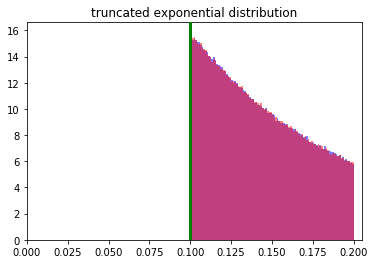

In [8]:
m = 1_000_000    # number of samples
B = 100          # number of bins in histogram

args = (10, .1, .2)

samples = [truncated_exponential_slow(*args) for _ in range(m)]
pl.hist(samples, bins=B, color='b', alpha=0.5, density=True)

samples = [truncated_exponential(*args) for _ in range(m)]
pl.hist(samples, bins=B, density=True, color='r', alpha=0.5)

pl.axvline(args[1], c='g', lw=3, zorder=100)            # show truncation line
pl.xlim(0, None)
pl.title('truncated exponential distribution');

In [14]:
samples = [exponential(2) for _ in range(10000)]
print(np.mean(samples))          # should equal 1/2
print(np.std(samples, ddof=1))   # should equal 1/2

0.5056888209589832
0.5098606176303817



## Why `expjumps` works

The way we're going to understand why this algorithm works is by showing that it simulates the first algorithm.

### Part 1: The "exponential jump"

The probability that we advance from the current position $c$ to some future position $i$ is equal to

$$
p\left( \sum_{j=c}^{i-1} w_j < J \le \sum_{j=c}^{i} w_j \right)
$$

Let $\ell=\sum_{j=c}^{i-1} w_j$

$$
\begin{eqnarray*}
 &=& p\left(               \ell < -\frac{\log(U)}{T} \le \ell + w_i         \right) \\
 &=& p\left(               1 < -\frac{\log(U)}{T \ell } \le 1 + \frac{w_i}{\ell}         \right) \\
 &=& p\left( -\frac{\log(U)}{T \ell } \le 1 + \frac{w_i}{\ell}         \right) \\
 &=& p\left( U  \ge  \exp(-T (\ell + w_i))         \right) \\ 
 &=& \exp(-T (\ell + w_i))
\end{eqnarray*}
$$

